# Proton NMR - Technical

## Imports and Definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import cm
from glob import glob
from scipy.optimize import curve_fit, minimize
from allantools import oadev

In [2]:
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.labelspacing'] = 0.2

In [3]:
%load_ext autoreload
%autoreload 2

from nmrLib import *

## Pump Flow Rate

In [119]:
# control voltage for the pump power in [V]
controlVoltage = np.array([2,2.5,3,3.5,4])
# time that the water was collected in [s]
pumpTime = np.array([30,0.5])
# tube radius in [cm]
tubeRadius = 0.002

In [120]:
# weight of the collected water in [g]
pumpVolume = np.array([[477.9,480.4,479.7,478.1,483.9],
                       [617.9,615.2,618.9,614.6,615.3],
                       [765.6,763.8,761.1,764.5,766.6],
                       [882.4,884.1,880.6,886.7,888.1],
                       [1000.9,996.3,1002.9,1002.0,997.8]])

pumpVolume = np.array([pumpVolume.mean(axis=1), pumpVolume.std(axis=1)])

# flow velocity through interaction region in [m/s]
flowVelocity = 1e-6*np.array([pumpVolume[0]/pumpTime[0]/(tubeRadius**2*np.pi), 
                              np.sqrt(pumpVolume[1]**2/pumpTime[0]**2/tubeRadius**4/np.pi**2 + pumpVolume[0]**2*pumpTime[1]**2/pumpTime[0]**4/tubeRadius**4/np.pi**2)])

# flow rate of pump in [l/min]
flowRate = 60/1000*np.array([pumpVolume[0]/pumpTime[0], 
                             np.sqrt(pumpVolume[1]**2/pumpTime[0]**2 + pumpVolume[0]**2*pumpTime[1]**2/pumpTime[0]**4)])

In [121]:
0.01 / flowVelocity[0]

array([0.00785398, 0.00611621, 0.00493237, 0.00426277, 0.00376999])

In [122]:
popt, pcov = np.polyfit(controlVoltage, flowVelocity[0], 1, w=1/flowVelocity[1], cov='unscaled')
perr = np.sqrt(np.diag(pcov))
print('{:.02f} +/- {:.02f} m/s/V'.format(popt[0], perr[0]))

popt, pcov = np.polyfit(controlVoltage, flowRate[0], 1, w=1/flowRate[1], cov='unscaled')
perr = np.sqrt(np.diag(pcov))
print('{:.02f} +/- {:.02f} l/min/V'.format(popt[0], perr[0]))

0.71 +/- 0.02 m/s/V
0.53 +/- 0.02 l/min/V


2.0 V: 1.27 m/s
2.5 V: 1.63 m/s
3.0 V: 2.03 m/s
3.5 V: 2.35 m/s
4.0 V: 2.65 m/s


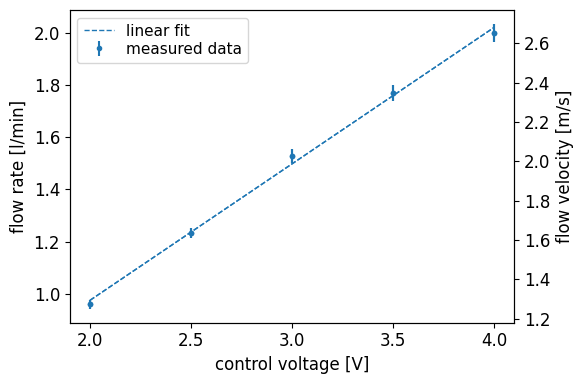

In [123]:
for i,(u,v) in enumerate(zip(controlVoltage, flowVelocity[0])):
    print('{} V: {:.02f} m/s'.format(u,v))


fig, ax = plt.subplots()

ax.errorbar(controlVoltage, flowRate[0], flowRate[1], fmt='C0.', label='measured data')
ax.plot(controlVoltage, np.polyval(np.polyfit(controlVoltage, flowRate[0], 1), controlVoltage), 'C0--', lw=1, label='linear fit')
ax.set(xlabel='control voltage [V]', ylabel='flow rate [l/min]')

ax2 = ax.twinx()
ax2.errorbar(controlVoltage, flowVelocity[0], flowVelocity[1], fmt='C0.')
ax2.plot(controlVoltage, np.polyval(np.polyfit(controlVoltage, flowVelocity[0], 1), controlVoltage), 'C0--', lw=1)
ax2.set(ylabel='flow velocity [m/s]')

ax.legend()
fig.set(dpi=100)
fig.tight_layout()

plt.show()

## NMR Signal

sampling interval:	7.8125 us


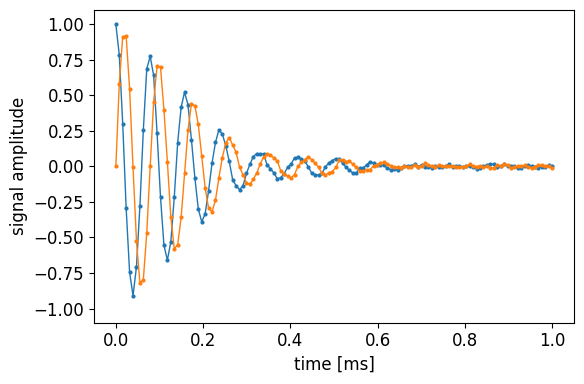

In [72]:
file = 'data/nmrSignal_reference.txt'

# spectral width in [Hz]
specWidth = 128e3

# sampling interval in [s]
tdwell = 1/specWidth
print('sampling interval:\t{} us'.format(1e6*tdwell))

# load the signal from the data file
sig = pd.read_csv(file, skiprows=12)
sig = (np.asarray(sig['[DATA]'][::2]) + 1.j*np.asarray(sig['[DATA]'][1::2]))

# create the time array
time = np.linspace(0, len(sig)*tdwell, len(sig))

# manually correct the phase of the signal
# shift by 20°
phase = 20
sig = sig * np.exp(-1.j*np.pi*phase/180)

# normalize the signal
sig = sig/sig.max()

popt = (12e3, 1, 90, 2e-4, -1e3)
popt, pcov = curve_fit(nmrSignal, time, sig.real, p0=popt)
perr = np.sqrt(np.diag(pcov))

#popt = (np.abs(sig).max(), 1e-4, 0)
#popt, pcov = curve_fit(relaxationTime, time, np.abs(sig), p0=popt)
#perr = np.sqrt(np.diag(pcov))
#print(popt[1]*1e6, perr[1]*1e6)


fig, ax = plt.subplots()
ax.plot(time*1e3, sig.real, 'C0.-', ms=4, lw=1)
ax.plot(time*1e3, sig.imag, 'C1.-', ms=4, lw=1)
ax.set(xlabel='time [ms]', ylabel='signal amplitude', ylim=(-1.1, 1.1))
fig.set(dpi=100)
fig.tight_layout()
plt.show()

sampling interval:	7.8125 us
178.54829122938312 5.182650479565441


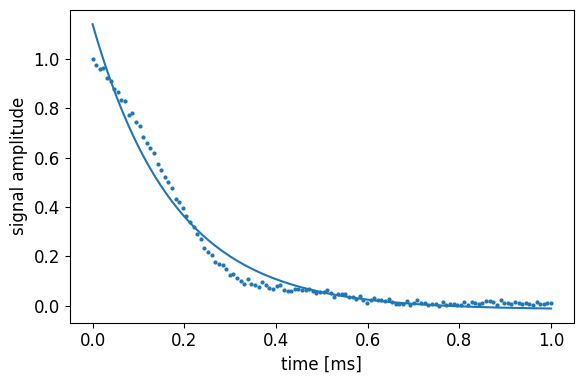

In [102]:
file = 'data/nmrSignal_reference.txt'

# spectral width in [Hz]
specWidth = 128e3

# sampling interval in [s]
tdwell = 1/specWidth
print('sampling interval:\t{} us'.format(1e6*tdwell))

# load the signal from the data file
sig = pd.read_csv(file, skiprows=12)
sig = (np.asarray(sig['[DATA]'][::2]) + 1.j*np.asarray(sig['[DATA]'][1::2]))

# create the time array
time = np.linspace(0, len(sig)*tdwell, len(sig))

# manually correct the phase of the signal
# shift by 20°
phase = 20
sig = sig * np.exp(-1.j*np.pi*phase/180)

# normalize the signal
sig = sig/sig.max()


popt = (np.abs(sig).max(), 1e-4, 0)
popt, pcov = curve_fit(relaxationTime, time, np.abs(sig), p0=popt)
perr = np.sqrt(np.diag(pcov))
print(popt[1]*1e6, perr[1]*1e6)


fig, ax = plt.subplots()
ax.plot(time*1e3, np.abs(sig), 'C0.', ms=4, lw=1)
ax.plot(time*1e3, relaxationTime(time, *popt), '-')
ax.set(xlabel='time [ms]', ylabel='signal amplitude')
fig.set(dpi=100)
fig.tight_layout()
plt.show()

sampling interval:	7.8125 us
exponential decay time:	(161 +/- 6) us


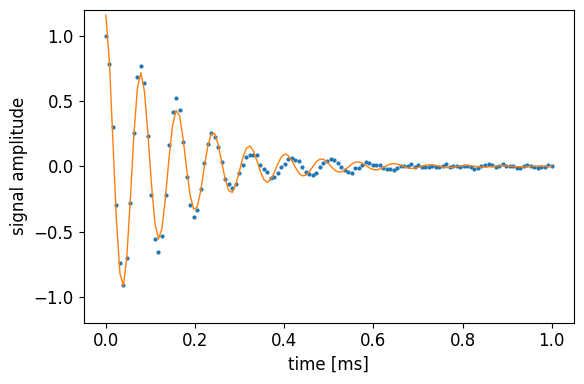

In [112]:
file = 'data/nmrSignal_reference.txt'

# spectral width in [Hz]
specWidth = 128e3

# sampling interval in [s]
tdwell = 1/specWidth
print('sampling interval:\t{} us'.format(1e6*tdwell))

# load the signal from the data file
sig = pd.read_csv(file, skiprows=12)
sig = (np.asarray(sig['[DATA]'][::2]) + 1.j*np.asarray(sig['[DATA]'][1::2]))

# create the time array
time = np.linspace(0, len(sig)*tdwell, len(sig))

# manually correct the phase of the signal
# shift by 20°
phase = 20
sig = sig * np.exp(-1.j*np.pi*phase/180)

# normalize the signal
sig = sig/sig.max()



popt = (12e3, 1, 90, 2e-4)
popt, pcov = curve_fit(nmrSignal, time, sig.real, p0=popt)
perr = np.sqrt(np.diag(pcov))
print('exponential decay time:\t({:.0f} +/- {:.0f}) us'.format(popt[3]*1e6, perr[3]*1e6))

fig, ax = plt.subplots()
ax.plot(time*1e3, sig.real, 'C0.', ms=4)
ax.plot(time*1e3, nmrSignal(time, *popt), 'C1-', lw=1)
ax.set(xlabel='time [ms]', ylabel='signal amplitude', ylim=(-1.2, 1.2))
fig.set(dpi=100)
fig.tight_layout()
plt.show()

## NMR Spectrum

X² / NDF:	12775 / 251 = 51
T2*:		(153 +/- 1) us


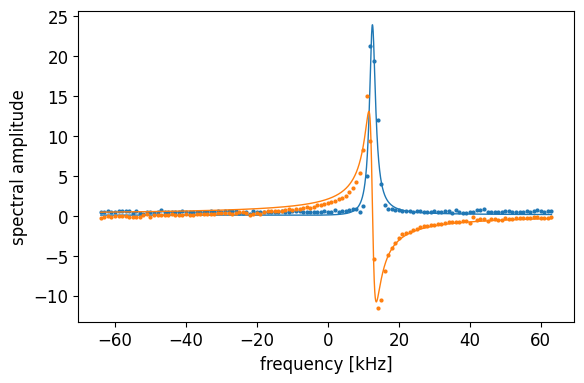

In [118]:
freq = np.fft.fftshift(np.fft.fftfreq(len(sig), d=tdwell))
spec = np.fft.fftshift(np.fft.fft(sig, n=len(sig), norm=None))
noise = spec[:len(spec)//2].real.std()
idx_max = 76
popt = (freq[idx_max],1e3*spec[idx_max].real,0.001,0,0)

popt, pcov = curve_fit(lorentzFitFct, np.hstack([freq,freq]), np.hstack([spec.real, spec.imag]), sigma=noise*np.ones(2*len(spec)), absolute_sigma=True, p0=popt, maxfev=100000)
perr = np.sqrt(np.diag(pcov))
chi2 = np.sum((np.hstack([spec.real, spec.imag])-lorentzFitFct(np.hstack([freq,freq]), *popt))**2 / (noise*np.ones(2*len(spec)))**2)
chi2_r = chi2 / (2*len(spec) - len(popt))

print('X² / NDF:\t{:.0f} / {} = {:.0f}'.format(chi2, (2*len(spec) - len(popt)), chi2_r))
print('T2*:\t\t({:.0f} +/- {:.0f}) us'.format(1e6*popt[2]/2/np.pi, 1e6*perr[2]/2/np.pi))

freqFit = np.linspace(freq.min(), freq.max(), 10001)

    
fig, ax = plt.subplots()
ax.plot(freq/1e3, spec.real, 'C0.', ms=4)
ax.plot(freqFit/1e3, lorentzFct(freqFit, *popt).real, 'C0-', lw=1)    
ax.plot(freq/1e3, spec.imag, 'C1.', ms=4)
ax.plot(freqFit/1e3, lorentzFct(freqFit, *popt).imag, 'C1-', lw=1)
ax.set(xlabel='frequency [kHz]', ylabel='spectral amplitude')
fig.set(dpi=100)
fig.tight_layout()
plt.show()